Two-Tower model because it has two separate "towers" (neural networks) that learn independently before meeting at the top.

* The Query Tower (User Tower):

Input: Who is the user? (user_id)

Goal: Learn a vector representing the user's preferences.

* The Candidate Tower (Item Tower):

Input: What is the item? (item_id, brand_id, category_id, title_vector)

Goal: Learn a vector representing the item's attributes.

* The Dot Product (The Match):

We multiply the User Vector by the Item Vector.

Result: A score (Probability) indicating how likely the user is to like this item.

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
import json
import os
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

## 01. Initial Setup

In [2]:

print(f"TensorFlow Version: {tf.__version__}")

# --- 1. Load the Final Mini Data ---
print("Loading final mini dataset...")
train_df = pd.read_parquet('../data/100k/train_final_mini.parquet')
val_df = pd.read_parquet('../data/100k/val_final_mini.parquet')
test_df = pd.read_parquet('../data/100k/test_final_mini.parquet')

print(f"Train shape: {train_df.shape}")
print(f"Val shape:   {val_df.shape}")
print(f"Test shape:  {test_df.shape}")

# --- 2. Load the Vocabularies (Mappings) ---
# to know how big our Embedding Layers should be
print("Loading vocabularies...")

def load_mapping(filename):
    with open(filename, 'r') as f:
        return json.load(f)

user_mapping = load_mapping('../data/user_mapping.json')
item_mapping = load_mapping('../data/item_mapping.json')
brand_mapping = load_mapping('../data/brand_mapping.json')
category_mapping = load_mapping('../data/category_mapping.json')

# Calculate vocabulary sizes (len + 1 for safety/padding)
num_users = len(user_mapping) + 1
num_items = len(item_mapping) + 1
num_brands = len(brand_mapping) + 1
num_categories = len(category_mapping) + 1

print(f"\nVocabulary Sizes:")
print(f"Users: {num_users}")
print(f"Items: {num_items}")
print(f"Brands: {num_brands}")
print(f"Categories: {num_categories}")

TensorFlow Version: 2.20.0
Loading final mini dataset...
Train shape: (80000, 14)
Val shape:   (10000, 14)
Test shape:  (10000, 14)
Loading vocabularies...

Vocabulary Sizes:
Users: 915326
Items: 235825
Brands: 31326
Categories: 1002


### 02 Prepare the Input Data
1. convert Pandas DataFrames into a format TensorFlow can understand
2. bit tricky because of the title_vector column. Pandas stores it as a "Series of Arrays," but TensorFlow needs a single "Matrix" (a 2D NumPy array).

It converts your DataFrames into a dictionary of inputs X and labels y

In [3]:
# --- Helper to convert DataFrame to TensorFlow Inputs ---
def prepare_data(df):
    """
    Converts a DataFrame into a dictionary of inputs (X) and a target array (y).
    """
    # 1. Extract the scalar features (IDs)
    # We convert to int32 to save memory
    user_ids = df['user_id'].values.astype('int32')
    item_ids = df['item_id'].values.astype('int32')
    brand_ids = df['brand_id'].values.astype('int32')
    category_ids = df['main_category_id'].values.astype('int32')
    
    # 2. Extract the Title Vectors
    # We must stack the list of arrays into a single 2D numpy matrix
    # Shape will be (num_rows, 384)
    title_vectors = np.stack(df['title_vector'].values).astype('float32')
    
    # 3. Create the Input Dictionary
    # The keys here MUST match the layer names in our model later
    X = {
        "user_input": user_ids,
        "item_input": item_ids,
        "brand_input": brand_ids,
        "category_input": category_ids,
        "text_input": title_vectors
    }
    
    # 4. Extract Target (Labels)
    y = df['positive'].values.astype('float32')
    
    return X, y

# --- Prepare all three splits ---
print("Preparing training data...")
X_train, y_train = prepare_data(train_df)

print("Preparing validation data...")
X_val, y_val = prepare_data(val_df)

print("Preparing test data...")
X_test, y_test = prepare_data(test_df)

# --- Verify Shapes ---
print("\nData preparation complete!")
print(f"User Input Shape: {X_train['user_input'].shape}")
print(f"Text Input Shape: {X_train['text_input'].shape}") # Should be (80000, 384)
print(f"Target Shape:     {y_train.shape}")

Preparing training data...
Preparing validation data...
Preparing test data...

Data preparation complete!
User Input Shape: (80000,)
Text Input Shape: (80000, 384)
Target Shape:     (80000,)


## Workflow
User Tower: Just takes the user_id -> Embedding.

Item Tower: Takes item_id, brand_id, category_id (all Embeddings) AND the title_vector (Dense layer). It concatenates (joins) them all together.

The Output: We calculate the Dot Product of the two towers to get a score, then pass it through a Sigmoid activation to get a probability (0 to 1).

## 3: Build the Two-Tower Model

In [5]:


def build_two_tower_model(
    num_users, num_items, num_brands, num_categories, 
    embedding_dim=32, vector_dim=384
):
    # --- 1. THE USER TOWER ---
    # Input
    user_input = Input(shape=(1,), name='user_input')
    # Embedding: Turns integer ID into a vector (e.g., length 32)
    user_embedding = layers.Embedding(num_users, embedding_dim, name='user_emb')(user_input)
    # Flatten: Turns (1, 32) into (32,)
    user_vec = layers.Flatten(name='user_flatten')(user_embedding)
    
    # --- 2. THE ITEM TOWER ---
    # Input A: Item ID
    item_input = Input(shape=(1,), name='item_input')
    item_emb = layers.Embedding(num_items, embedding_dim, name='item_emb')(item_input)
    item_vec = layers.Flatten()(item_emb)
    
    # Input B: Brand ID
    brand_input = Input(shape=(1,), name='brand_input')
    brand_emb = layers.Embedding(num_brands, 16, name='brand_emb')(brand_input) # Smaller dim for brands
    brand_vec = layers.Flatten()(brand_emb)
    
    # Input C: Category ID
    category_input = Input(shape=(1,), name='category_input')
    category_emb = layers.Embedding(num_categories, 16, name='category_emb')(category_input)
    category_vec = layers.Flatten()(category_emb)
    
    # Input D: Text Vector (Pre-computed 384-dim vector)
    text_input = Input(shape=(vector_dim,), name='text_input')
    # We pass the text vector through a Dense layer to compress/tune it
    text_vec = layers.Dense(32, activation='relu', name='text_dense')(text_input)
    
    # MERGE ITEM FEATURES
    # We combine all item info into one big vector
    item_merged = layers.Concatenate()([item_vec, brand_vec, category_vec, text_vec])
    
    # Dense layer to mix the features and output the final "Item Vector"
    # Important: This MUST match the size of the User Vector (embedding_dim=32)
    item_final_vec = layers.Dense(embedding_dim, activation='relu', name='item_final')(item_merged)
    
    # --- 3. THE MATCH (Dot Product) ---
    # Multiply User Vector * Item Vector
    # If they are similar, the result is high.
    dot_product = layers.Dot(axes=1)([user_vec, item_final_vec])
    
    # Output: Sigmoid activation to get probability (0 to 1)
    output = layers.Dense(1, activation='sigmoid', name='output')(dot_product)
    
    # --- Build Model ---
    model = Model(
        inputs=[user_input, item_input, brand_input, category_input, text_input],
        outputs=output,
        name="TwoTower_Hybrid"
    )
    
    return model

# --- Instantiate and Compile ---
# We use the vocabulary sizes we calculated earlier
model = build_two_tower_model(
    num_users=num_users, 
    num_items=num_items, 
    num_brands=num_brands, 
    num_categories=num_categories,
    embedding_dim=32
)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', # Since we are predicting 0 vs 1
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()

Model: "TwoTower_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ brand_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_emb            │ (None, 1, 32)     │  7,546,400 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ brand_emb           │ (None, 1, 16)     │    501,216 │ brand_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_emb        │ (None, 1, 16)     │     16,032 │ category_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 384)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ item_emb[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 16)        │          0 │ brand_emb[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 16)        │          0 │ category_emb[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_dense (Dense)  │ (None, 32)        │     12,320 │ text_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_emb            │ (None, 1, 32)     │ 29,290,432 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ text_dense[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_flatten        │ (None, 32)        │          0 │ user_emb[0][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_final (Dense)  │ (None, 32)        │      3,104 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ user_flatten[0][… │
│                     │                   │            │ item_final[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │          2 │ dot[0][0]       

 Total params: 37,369,506 (142.55 MB)

 Trainable params: 37,369,506 (142.55 MB)

 Non-trainable params: 0 (0.00 B)

## 4: Train the Model
use Early Stopping. This is a safety mechanism that monitors the validation loss. If the model starts "memorizing" the training data (overfitting) instead of learning, it stops training automatically to save time and give you the best version.

In [7]:
print("Starting training...")

# Define the callback: Stop if 'val_loss' doesn't improve for 3 epochs
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

# --- TRAIN THE MODEL ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,            # Max epochs (it will stop earlier likely)
    batch_size=256,       # Process 256 rows at a time
    callbacks=[early_stopping],
    verbose=1
)

print("Training complete!")

Starting training...
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 95ms/step - accuracy: 0.7977 - auc: 0.4991 - loss: 0.6514 - val_accuracy: 0.7622 - val_auc: 0.5184 - val_loss: 0.6264
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - accuracy: 0.8859 - auc: 0.9123 - loss: 0.3320 - val_accuracy: 0.6786 - val_auc: 0.5202 - val_loss: 0.7376
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - accuracy: 0.9852 - auc: 0.9985 - loss: 0.0393 - val_accuracy: 0.6793 - val_auc: 0.5191 - val_loss: 0.7404
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/step - accuracy: 0.9849 - auc: 0.9995 - loss: 0.0312 - val_accuracy: 0.6813 - val_auc: 0.5197 - val_loss: 0.7333
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Training complete!


## 5: Visualize Performance

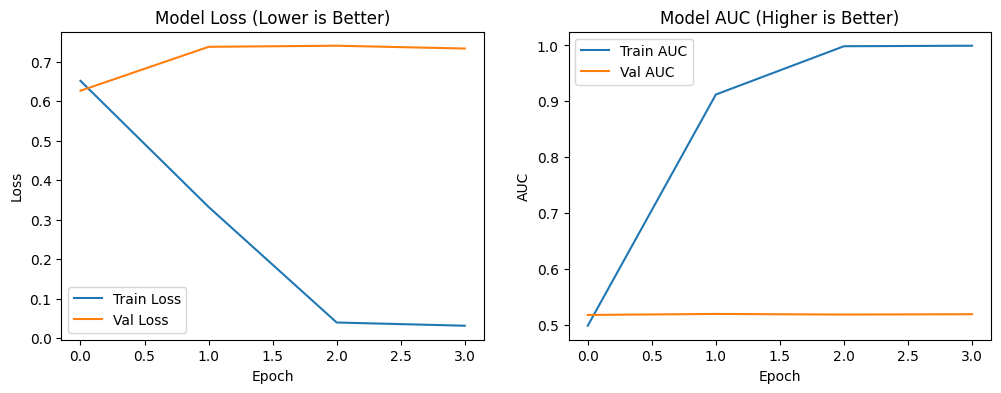

In [9]:

def plot_history(history):
    # Plot Loss
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss (Lower is Better)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot AUC (Area Under Curve)
    # Note: If your metric name in model.compile was just 'auc', use that.
    # Keras sometimes adds '_1' if there are duplicates. Check history.history.keys() if it fails.
    auc_key = [k for k in history.history.keys() if 'auc' in k and 'val' not in k][0]
    val_auc_key = [k for k in history.history.keys() if 'auc' in k and 'val' in k][0]
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history[auc_key], label='Train AUC')
    plt.plot(history.history[val_auc_key], label='Val AUC')
    plt.title('Model AUC (Higher is Better)')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.show()

plot_history(history)

## quick eval

In [10]:
from tensorflow.keras import Model

print("Extracting Item Tower...")

# 1. Identify the layer that outputs the final Item Vector
# In your summary, it was named 'item_final'
item_tower_output = model.get_layer('item_final').output

# 2. Create a new model that just runs the Item Tower
item_tower_model = Model(
    inputs=[
        model.input[1], # item_input
        model.input[2], # brand_input
        model.input[3], # category_input
        model.input[4]  # text_input
    ],
    outputs=item_tower_output
)

print("Item Tower extracted!")
item_tower_model.summary()

Extracting Item Tower...
Item Tower extracted!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ brand_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_emb            │ (None, 1, 32)     │  7,546,400 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ brand_emb           │ (None, 1, 16)     │    501,216 │ brand_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_emb        │ (None, 1, 16)     │     16,032 │ category_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 384)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ item_emb[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 16)        │          0 │ brand_emb[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 16)        │          0 │ category_emb[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_dense (Dense)  │ (None, 32)        │     12,320 │ text_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ text_dense[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_final (Dense)  │ (None, 32)        │      3,104 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,079,072 (30.82 MB)

 Trainable params: 8,079,072 (30.82 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# --- CORRECTED TASK 2: Generate Vectors ---
print("Generating vectors for all unique items...")

# 1. Create the dataframe AND RESET INDEX immediately
# drop=True discards the old confusing index
all_items_df = pd.concat([train_df, val_df, test_df]) \
                 .drop_duplicates(subset=['item_id']) \
                 .reset_index(drop=True)

print(f"Unique items found: {len(all_items_df)}")

# 2. Prepare inputs (Standard Process)
item_inputs = [
    all_items_df['item_id'].values.astype('int32'),
    all_items_df['brand_id'].values.astype('int32'),
    all_items_df['main_category_id'].values.astype('int32'),
    np.stack(all_items_df['title_vector'].values).astype('float32')
]

# 3. Predict Embeddings
item_embeddings = item_tower_model.predict(item_inputs, batch_size=256, verbose=1)

# 4. Normalize (L2 Norm) for Cosine Similarity
norms = np.linalg.norm(item_embeddings, axis=1, keepdims=True)
item_embeddings = item_embeddings / (norms + 1e-10)

print(f"Embeddings ready! Shape: {item_embeddings.shape}")


# --- CORRECTED TASK 3: Recommendation Function ---
def recommend_similar_items(item_title, top_k=5):
    # Search for the item title (case insensitive)
    matches = all_items_df[all_items_df['title'].str.contains(item_title, case=False, na=False)]
    
    if len(matches) == 0:
        print(f"Item '{item_title}' not found.")
        return

    # Take the first match found
    target_row = matches.iloc[0]
    
    # Since we reset the index, the row's 'name' IS its integer index
    target_idx = target_row.name 
    
    # Get the vector for this item (Shape: 1, 32)
    target_vector = item_embeddings[target_idx].reshape(1, -1)
    
    print(f"Query:    {target_row['title']}")
    print(f"Category: {target_row['main_category']}")
    print("-" * 50)
    
    # Calculate Similarity (Dot Product because vectors are normalized)
    # Shape: (N, 32) @ (32, 1) -> (N, 1)
    sim_scores = np.dot(item_embeddings, target_vector.T).flatten()
    
    # Get Top K indices (fastest way)
    # 1. Partition the array to get top K unsorted
    top_indices = np.argpartition(sim_scores, -top_k)[-top_k:]
    # 2. Sort just those top K
    top_indices = top_indices[np.argsort(sim_scores[top_indices])[::-1]]
    
    # Print Results
    for idx in top_indices:
        if idx == target_idx: continue # Skip the query item itself
            
        rec_item = all_items_df.iloc[idx]
        score = sim_scores[idx]
        print(f"[{score:.4f}] {rec_item['title']}")

# --- RETEST ---
print("\n--- Test 1: Headphones ---")
recommend_similar_items("Headphones", top_k=5)

print("\n--- Test 2: Dell ---")
recommend_similar_items("Dell", top_k=5)

Generating vectors for all unique items...
Unique items found: 48629
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
Embeddings ready! Shape: (48629, 32)

--- Test 1: Headphones ---
Query:    Sony MDRZX110NC Noise Cancelling Headphones, Black, medium
Category: Over-Ear Headphones
--------------------------------------------------
[0.9752] X-Rite ColorMunki Smile (CMUNSML)
[0.9751] Sennheiser HD 419 Headphones, Black
[0.9719] Sony MDR-Q23LP w.ear Stereo Headphones (Black & Orange)
[0.9719] Bose QuietComfort 35 (Series II) Wireless Headphones, Noise Cancelling, with Alexa voice control – Limited Edition Triple Midnight

--- Test 2: Dell ---
Query:    Dell Inspiron 3452 HD High Performance Laptop NoteBook PC (Intel Celeron N3060, 2GB Ram, 32GB Solid State SSD, HDMI, Camera, WIFI, SC Card Reader) Windows 10 (Renewed)
Category: Traditional Laptops
--------------------------------------------------
[0.9944] 2018 Acer 14' FHD IPS Display Premium Flagship Business Chromebook-Intel Celeron Quad-Core

## Saving the model

In [15]:
print("Saving model artifacts...")

# 1. Save the Keras Model
# We save in the modern .keras format
model.save('../data/100k/two_tower_model_100k.keras')
print("- Model saved to '../data/100k/two_tower_model_100k.keras'")

# 2. Save the Item Embeddings (The "Fingerprints")
# This allows us to make recommendations instantly without running the model
np.save('../data/100k/item_embeddings_100k.npy', item_embeddings)
print("- Item Embeddings saved to '../data/100k/item_embeddings_100k.npy'")

# 3. Save the Item Dataframe (so we can look up titles later)
all_items_df.to_parquet('../data/100k/all_items_processed_100k.parquet', index=False)
print("- Item Dataframe saved to '../data/100k/all_items_processed_100k.parquet'")


Saving model artifacts...
- Model saved to '../data/100k/two_tower_model_100k.keras'
- Item Embeddings saved to '../data/100k/item_embeddings_100k.npy'
- Item Dataframe saved to '../data/100k/all_items_processed_100k.parquet'
